**Necessary Importings**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from einops import rearrange
import copy
import time
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

**Data transforms**

In [ ]:
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(128, padding=4),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3))
])

transform_test = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Attention**

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads=6, dropout=0.1):
        super().__init__()
        self.att = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, dropout=dropout, batch_first=False)
    def forward(self, x):
        x = x.transpose(0,1)  #seq_len, batch, dim
        attn_out, _ = self.att(x, x, x)
        return attn_out.transpose(0,1)

**MLP**

In [ ]:
class MLP(nn.Module):
  #multilayer perceptron
  #it captures the complex patterns and learns non linear relationships
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

**Transformer Block**

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, n_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, n_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_dim, dropout)
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
def spt_shift(x):
    """
    Shifted Patch Tokenization for ViT.
    x: input tensor (B, C, H, W)
    Returns tensor with shifted images stacked along batch dimension
    """
    #I found this method was used by DeepLearning.Ai for small datasets
    B, C, H, W = x.shape
    shifts = [-1, 0, 1]  #pixel shifts in H and W
    shifted_images = []
    for dx in shifts:
        for dy in shifts:
            shifted = torch.roll(x, shifts=(dx, dy), dims=(2,3))
            shifted_images.append(shifted)
    return torch.cat(shifted_images, dim=0)

**ViT Model**

In [ ]:
class ViT_SPT(nn.Module):
    def __init__(self, *, image_size=128, patch_size=16, in_channels=3,
                 num_classes=10, dim=192, depth=8, n_heads=6, mlp_dim=768, dropout=0.1):
        super().__init__()
        assert image_size % patch_size == 0
        num_patches = (image_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches+1, dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(dim=dim, n_heads=n_heads, mlp_dim=mlp_dim, dropout=dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)
        self.patch_size = patch_size

    def forward(self, x):
        #Applying SPT
        x = spt_shift(x)
        B = x.shape[0]
        #Patch embedding
        patches = self.patch_embed(x)
        patches = patches.flatten(2).transpose(1,2)
        #CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, patches), dim=1)
        x = x + self.pos_embed

        #Transformer blocks
        for block in self.blocks:
            x = block(x)

        cls_out = x[:,0,:]
        logits = self.head(self.norm(cls_out))
        return logits


**Initializing model**

In [ ]:
model = ViT(image_size=128, patch_size=16, dim=192, depth=8, n_heads=6, mlp_dim=768, dropout=0.1).to(device)

**Loss, optimizer, scheduler**

In [ ]:
import numpy as np
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)

num_epochs = 50
warmup_epochs = 5
base_lr = 5e-4
min_lr = 1e-6

def cosine_warmup_lr(epoch: int):
    if epoch < warmup_epochs:
        #Linear warmup
        return float(epoch + 1) / warmup_epochs
    else:
        decay_epochs = num_epochs - warmup_epochs
        cosine_decay = 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / decay_epochs))
        return min_lr/base_lr + (1 - min_lr/base_lr) * cosine_decay

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=cosine_warmup_lr, last_epoch=-1)


**Early stopping setup**

In [ ]:
patience = 5
trigger_times = 0
best_model = copy.deepcopy(model.state_dict())
num_epochs = 50
#This can be Increased but for smaller dataset I felt this is sufficient because after particular number of epochs there is not much imporvement in accuracy

**Training Loop**

In [ ]:
best_acc=0
train_acc_list, val_acc_list, train_loss_list = [], [], []
def training(num_epochs):
    global best_acc
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * images.size(0)

        scheduler.step()

        #Validation
        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        train_acc = correct / total
        test_acc = correct_test / total_test
        train_loss = running_loss / total
        train_acc_list.append(train_acc)
        val_acc_list.append(test_acc)
        train_loss_list.append(train_loss)
        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Test Acc: {test_acc*100:.2f}% | Time: {epoch_time:.1f}s")

        if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model.state_dict())
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

In [ ]:
training(50)

Epoch [1/50] | Train Loss: 2.0508 | Train Acc: 26.96% | Test Acc: 45.30% | Time: 56.4s
Epoch [2/50] | Train Loss: 1.8283 | Train Acc: 38.83% | Test Acc: 50.34% | Time: 55.7s
Epoch [3/50] | Train Loss: 1.7343 | Train Acc: 42.64% | Test Acc: 53.42% | Time: 55.9s
Epoch [4/50] | Train Loss: 1.6797 | Train Acc: 45.52% | Test Acc: 57.72% | Time: 55.4s
Epoch [5/50] | Train Loss: 1.6356 | Train Acc: 47.83% | Test Acc: 59.79% | Time: 55.5s
Epoch [6/50] | Train Loss: 1.5793 | Train Acc: 50.59% | Test Acc: 60.36% | Time: 55.7s
Epoch [7/50] | Train Loss: 1.5505 | Train Acc: 51.83% | Test Acc: 61.17% | Time: 55.8s
Epoch [8/50] | Train Loss: 1.5128 | Train Acc: 53.73% | Test Acc: 64.54% | Time: 55.9s
Epoch [9/50] | Train Loss: 1.4783 | Train Acc: 55.13% | Test Acc: 63.02% | Time: 55.6s
Epoch [10/50] | Train Loss: 1.4542 | Train Acc: 56.53% | Test Acc: 65.56% | Time: 55.6s
Epoch [11/50] | Train Loss: 1.4282 | Train Acc: 57.73% | Test Acc: 66.35% | Time: 56.0s
Epoch [12/50] | Train Loss: 1.4020 | Trai

In [ ]:
best_acc

0.8374

In [ ]:
model.load_state_dict(best_model)
print(f"\nBest Test Accuracy: {best_acc*100:.2f}%")


Best Test Accuracy: 83.74%


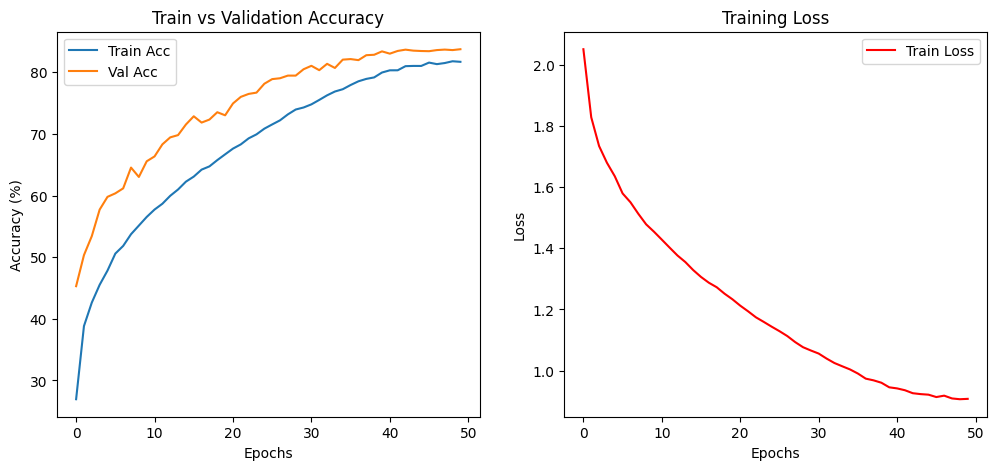

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([x*100 for x in train_acc_list], label='Train Acc')
plt.plot([x*100 for x in val_acc_list], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Train vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(train_loss_list, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

As per ViT research paper I initially started with using 224x224 by resizing the images but due to limited gpu access and higher time usage per epoch than 128x128 Image_Size I moved with it to make efficient usage of time